In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Twitter Developer Account
In order to use Twitter’s API, we have to create a developer account on the Twitter apps site.
 * Log in or make a Twitter account at https://apps.twitter.com/.
 * Create a new app (button on the top right)
 
<img src=https://miro.medium.com/max/1400/0*Dq78m3JKoSqZY5SS.png style="width: 200px;">

Fill in the app creation page with a unique name, a website name (use a placeholder website if you don’t have one), and a project description. Accept the terms and conditions and proceed to the next page.

Once your project has been created, click on the “Keys and Access Tokens” tab. You should now be able to see your consumer secret and consumer key.

<img src=https://miro.medium.com/max/1400/0*YU1pFqTw6Dn-ZmOd.png style="width: 200px;">

You’ll also need a pair of access tokens. Scroll down and request those tokens. The page should refresh, and you should now have an access token and access token secret.

<img src=https://miro.medium.com/max/1400/0*_gnOgA0aaAqPgDJG.png style="width: 200px;">


## Import necessary modules

In [2]:
import sys
import os
import json
import re
import string
import pandas as pd
import matplotlib.pyplot as pltr

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Starting code
Below we define some starting codes (python classes and function) to illustrate and assist on how to fetch data from twitter and analyse them. 

### **Your task is**
1. Go through the code and understand it. Know what each function does
2. If you find error, fix it. Ask for help in the slack channel if you find serious mistake
3. Extend the code such that it will be useful for topics you choose to analyse
4. Make nice plots and share your finding (e.g.  insight on the main covid19 twitter converstions about your country)
5. Submit what ever you managed to do by Wednesday morning. But you should keep using what you build to write blogs, share on facebook, etc. 

In [31]:
class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self, cols=None,auth=None):
        if cols is None:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author',   
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
        else:
            self.cols = cols
  
            
        if auth is None:
            #Variables that contains the user credentials to access Twitter API 
            consumer_key = os.environ.get('TWITTER_API_KEY')
            consumer_secret = os.environ.get('TWITTER_API_SECRET')
            access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
            access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')


            #This handles Twitter authetification and the connection to Twitter Streaming API
            auth = OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_token_secret)
            

        #            
        self.auth = auth
        self.api = tweepy.API(auth)            
            

    def clean_tweets(self, twitter_text):
        self.twitter_text = twitter_text
        #use pre processor
        tweet = p.clean(self.twitter_text)

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        #combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        self.filtered_tweet = ' '.join(filtered_tweet)
    def get_tweets(self, keyword, csvfile=None):
        
        
        df = pd.DataFrame(columns=self.cols)
        
        if not csvfile is None:
            #If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
            

        #page attribute in tweepy.cursor and iteration
        for page in tweepy.Cursor(api.search, q=keyword,count=200, include_rt=False).pages(70):


            for status in page:
                
                new_entry = []
                status = status._json
                
                #filter by language
                if status['lang'] != 'en':
                    continue

                
                #if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    #
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue
                self.clean_tweets(status['text'])

                #calculate sentiment
                blob = TextBlob(self.filtered_tweet)
                Sentiment = blob.sentiment     
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['text'],self.filtered_tweet, 
                              Sentiment,polarity,subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])

                try:
                    is_sensitive = status['possibly_sensitive']
                except KeyError:
                    is_sensitive = None

                new_entry.append(is_sensitive)

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) #append the hashtags

                #
                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions) #append the user mentions

                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                #
                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                #
                new_entry.append(location)

                #now append a row to the dataframe
                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)

        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, columns=self.cols, index=False, encoding="utf-8")
            
        return df



### Search twitter and fetch data example

In [ ]:
covid_keywords = '#COVID19Nigeria OR #COVID19Lasg'  #hashtag based search
tweets_file = 'data/ethiopia_covid19_23june2020.json'

#get data on keywords
ts = tweetsearch()
df = ts.get_tweets(covid_keywords)    #you saved the 

In [55]:
df.head()

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,1278205413087940614,Wed Jul 01 05:54:53 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...","RT @firsNigeria: FIRS Adesive Stamp Launch, at...",FIRS Adesive Stamp Launch Transcorp Hilton tod...,"(0.0, 0.0)",0.000000,0.000000,en,0,3,kasmoli,None,"StampDutyLaunch, StampDutyAuditandRecovery",firsNigeria,None,"Kaduna, Nigeria"
1,1278205373606965249,Wed Jul 01 05:54:43 +0000 2020,"<a href=""http://twitter.com/download/android"" ...","RT @_yusufdexter: STATE CASES: \nTuesday, June...",STATE CASES Tuesday June update Recovered Acti...,"(-0.13333333333333333, 0.6)",-0.133333,0.600000,en,0,3,lawal_hawa,None,COVID19Nigeria,_yusufdexter,None,"Ife, Nigeria"
2,1278205000095850498,Wed Jul 01 05:53:14 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @visualData9: #COVID19Nigeria On the 30th ...,On th June new confirmed cases deaths recorded...,"(0.2681818181818182, 0.7272727272727273)",0.268182,0.727273,en,0,3,djgreat121,None,COVID19Nigeria,visualData9,None,Ibadan
3,1278203128215715842,Wed Jul 01 05:45:48 +0000 2020,"<a href=""http://twitter.com/download/android"" ...","RT @NCDCgov: “At the onset of #COVID19Nigeria,...",At onset people expected see critically ill pa...,"(-0.3, 0.7)",-0.300000,0.700000,en,0,22,AndOneDynasty,None,COVID19Nigeria,NCDCgov,None,
4,1278201389064257536,Wed Jul 01 05:38:53 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @BTBreakingTimes: NCDC'S #COVID19 UPDATE FO...,NCDC 'S UPDATE FOR TUESDAY JUNE New Cases New ...,"(0.13636363636363635, 0.45454545454545453)",0.136364,0.454545,en,0,3,SirALfredson,None,COVID19,BTBreakingTimes,None,


In [56]:
df.to_csv("data.csv", encoding='utf-8')

## Stream data and save it to file
In the above we saw how to search and fetch data, below we will see how we will stream data from twitter. Make sure you understand the difference between search and stream features of twitter api.

### **SAME TASK AS ABOVE**


In [ ]:
#This is a basic listener that writes received tweets to file.
class StdOutListener(StreamListener):

    def __init__(self,fhandle, stop_at = 1000):
        self.tweet_counter = 0
        self.stop_at = stop_at
        self.fhandle = fhandle
         
        
    def on_data(self, data):
        self.fhandle.write(data)
        
        #stop if enough tweets are obtained
        self.tweet_counter += 1   
        if self.tweet_counter < self.stop_at:        
            return True
        else:
            print('Max number of tweets reached: #tweets = ' + str(self.tweet_counter))
            return False

    def on_error(self, status):
        print (status)

def stream_tweet_data(
                      keywords=['COVID19Africa','COVID19Ethiopia'],
                      is_async=False):
    # tweet topics to use as a filter. The tweets downloaded
    # will have one of the topics in their text or hashtag 

    print('saving data to file: ',filename)

    #print the tweet topics 
    print('TweetKeywords are: ',keywords)
    print('For testing case, please interupt the downloading process using ctrl+x after about 5 mins ')
    print('To keep streaming in the background, pass is_async=True')

    #Variables that contains the user credentials to access Twitter API 
    consumer_key = os.environ.get('TWITTER_API_KEY')
    consumer_secret = os.environ.get('TWITTER_API_SECRET')
    access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
    access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

    #open file 
    fhandle=open(filename,'w')

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener(fhandle)
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: first argument to this code
    stream.filter(track=keywords,is_async=is_async)

    return None



### Use case of the above code

In [ ]:
tweets_file = 'data/ethiopia_covid19_23june2020.json'
stream_tweet_data(filename=tweets_file,keywords=['covid19'])

### Filter twitter data and do basic analysis
**Extend it to gain more insight**

In [ ]:
tweets_data = []
for line in open(tweets_file, "r"):
    try:
        tweet = json.loads(line)
        x=tweet['text']
        tweets_data.append(tweet)
    except:
        continue


print('saved numbers of tweets: ', len(tweets_data))

saved numbers of tweets:  998


In [ ]:
tweets = pd.DataFrame(columns=['text','lang','country'])

tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['country'] = list(map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, 
                             tweets_data))


tweets_by_lang = tweets['lang'].value_counts()

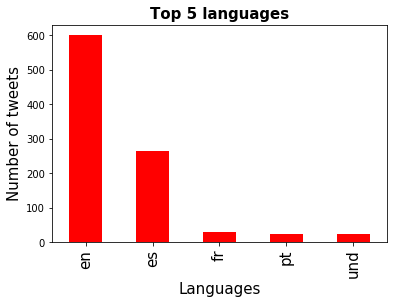

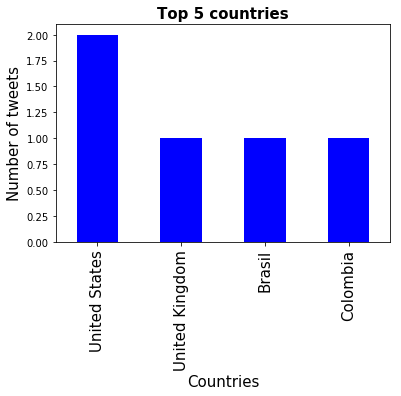

In [ ]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

# Hashtag histogram. 

## Please write code that will help you answer the following questions
 1) What is the most used hashtag?
 
 2) What is the most used referenced username?
 
 3) What is the most retweeted tweet?

### The most used hashtag can be found by checking the number of unique values in the hashtag column

740

In [57]:
hashtag = df['hashtags'].value_counts().reset_index()
hashtag.head()
#The most used Hashtag in Ngeria is the COVID19Nigeria and it didn't return an hashtag 740 times

,index,hashtags
0,,733
1,COVID19Nigeria,376
2,"COVID19Nigeria, COVID19",284
3,COVID19,48
4,"COVID19Nigeria, CTVLiveTweets",42


###   The most referenced username can be gotten from the mention column in the Dataframe

In [58]:
reference =df['user_mentions'].value_counts().reset_index()
reference.head()
#The most reference username is ChannelsTV a popular news channel in Nigeria

,index,user_mentions
0,channelstv,403
1,,388
2,NCDCgov,263
3,YeleSowore,54
4,RotimiAkeredolu,49


In [59]:
df['retweet_count'] = df['retweet_count'].astype('int') 

In [62]:
df.iloc[df['retweet_count'].idxmax()]
#The most retweeted tweet is a tweet by DREWRB7 about the government of nigeria


id                                                      1278135943346753537
created_at                                   Wed Jul 01 01:18:50 +0000 2020
source                    <a href="http://twitter.com/download/android" ...
original_text             RT @segalink: What they said and what’s on gro...
clean_text                What said whats ground Lets check situation re...
sentiment                                                        (0.0, 0.0)
polarity                                                                  0
subjectivity                                                              0
lang                                                                     en
favorite_count                                                            0
retweet_count                                                          3364
original_author                                                     DrewRB7
possibly_sensitive                                                     None
hashtags    